# HAMP Data Handling

This script handles HAMP data from measurement state up to unified gridded data

#### The processing to unified grid data follows Konow et al. (2019),  https://doi.org/10.5194/essd-11-921-2019

HAMP comprises microwave radiometers with 26 channels in the frequency range 
between 20 and 183 GHz and a 35 GHz cloud radar.

### Import

In [41]:
#major packages
import glob
import os 
import pickle
import sys

import numpy as np
import pandas as pd
import xarray as xr
# specific configuration packages 
import config_handler
import Performance
import campaign_time 
# Major processing packages
import radar_attitude
import radar_masks
import unified_grid as unigrid

## General specifications

In [61]:
campaign="HALO_AC3"
flight="RF05"
# Switches for tasks to be done by notebook. 
# Here all major performance information are given. 
# Change them if you want to select other processing steps

perform_raw_quicklooks=True
perform_error_identification=False
perform_processing=True
show_processed_results=False

### Configuration

#### Load config class and define

In [62]:
# load config files
cfg=config_handler.Configuration(major_path=os.getcwd())
processing_cfg_name="unified_grid_cfg"    
major_cfg_name="major_cfg"

In [63]:
# Campaign
campaign="HALO_AC3"
# Comments for data files
# Specify comment to be included into data files
comment = 'Preliminary data! Uncalibrated Data. Only use for preliminary work!'
# Specify contact information
contact = 'henning.dorff@uni-hamburg.de'

In [64]:
cfg=cfg.return_default_config_dict(major_cfg_name,processing_cfg_name,
                                   campaign,comment=comment,
                                   contact=contact)


=================== Configuration ============================
Create Config_file
C:\Users\u300737\Desktop\PhD_UHH_WIMI\Work\GIT_Repository\hamp_processing_py\hamp_processing_python/major_cfg.ini
Config-File  major_cfg.ini is created!
Create Config_file
C:\Users\u300737\Desktop\PhD_UHH_WIMI\Work\GIT_Repository\hamp_processing_py\hamp_processing_python/unified_grid_cfg.ini
Config-File  unified_grid_cfg.ini is created!
Config-file major_cfg.ini  already exists
C:\Users\u300737\Desktop\PhD_UHH_WIMI\Work\GIT_Repository\hamp_processing_py\hamp_processing_python/major_cfg.ini
Config-file unified_grid_cfg.ini  already exists
C:\Users\u300737\Desktop\PhD_UHH_WIMI\Work\GIT_Repository\hamp_processing_py\hamp_processing_python/unified_grid_cfg.ini
Entries:  dict_keys(['system', 'campaign_path', 'save_path']) have added to or changed in the config file
Entries:  dict_keys(['Comment', 'Contact']) have added to or changed in the config file
Entries:  dict_keys(['system', 'campaign_path', 'save_path'

## Campaign Packages

Either the flight campaign class is accessible or the flights have to be specified as shown here for EUREC4A

In [65]:
#Output file name prefix
# The usual file name will follow the format: 
# <instrument>_<date>_v<version-number>.nc
# An additional file name prefix can be specified here (e.g. for EUREC4A),

# if no prefix is necessary, set to empty string ('')
# #filenameprefix = 'EUREC4A_HALO_';
#     filenameprefix = ''
filenameprefix = campaign+'_HALO_'

In [66]:
from measurement_instruments_ql import HALO_Devices, RADAR, HAMP
try:
    import Flight_Campaign as Campaign
except:
    print("Module Flight Campaign is not listed in the path",
          "Flights need to be defined manually.")
    Flight_Dates={}
    FlightDays={}
    Flight_Dates["EUREC4A"]={"RF01":"20200119","RF02":"20200122",
                             "RF03":"20200124","RF04":"20200126",
                             "RF05":"20200128","RF06":"20200130",
                             "RF07":"20200131","RF08":"20200202",
                             "RF09":"20200205","RF10":"20200207",
                             "RF11":"20200209","RF12":"20200211",
                             "RF13":"20200213","RF14":"20200215",
                             "RF15":"20200218"}
    Flight_Dates["NAWDEX"]={} # to be filled
    Flight_Dates["NARVALII"]={} # to be filled
    Flight_Dates["NAWDEX"]={} # to be filled

    Flight_Dates["HALO_AC3"]={"RF00":"20220225",
                          "RF01":"20220311", # if this is the transfer flight
                          "RF02":"20220312",
                          "RF03":"20220313",
                          "RF04":"20220314",
                          "RF05":"20220315",
                          "RF06":"20220316",
                          "RF07":"20220320",
                          "RF08":"20220321",
                          "RF09":"20220328",
                          "RF10":"20220329",
                          "RF11":"20220330",
                          "RF12":"20220401",
                          "RF13":"20220404",
                          "RF14":"20220407",
                          "RF15":"20220408",
                          "RF16":"20220410",
                          "RF17":"20220411",
                          "RF18":"20220412"}

    FlightDays["HALO_AC3"]={"20220225":"00",
                        "20220311":"01",
                        "20220312":"02",
                        "20220313":"03"}

Module Flight Campaign is not listed in the path Flights need to be defined manually.


# Specifications

### Processing specification

#### Set version information
#### Missing value
    set value for missing value (pixels with no measured signal). 
    This should be different from NaN, 
    since NaN is used as fill value 
    (pixels where no measurements were conducted)#
    Set threshold for altitude to discard radiometer data
    Set threshold for roll angle to discard radiometer data



In [67]:
#Specify time frame for data conversion
start_date = Flight_Dates[campaign][flight]#'20200205'; # "20200131"  
end_date = Flight_Dates[campaign][flight]#'20200205';   # "20200205"


cfg.add_entries_to_config_object(processing_cfg_name,
                                 {"t1":start_date,
                                  "t2":end_date,
                                  "date":start_date,
                                  
                                  "flight_date_used":start_date,
                                  "unify_Grid":True,               # default True
                                  "fill_gaps":True,
                                  "correct_attitude":False,          # default False
                                  "add_radarmask":False,            # default True
                                  "remove_clutter":True,           # default True
                                  "remove_side_lobes":True,        # default True
                                  "remove_radiometer_errors":True, # default True
                                  
                                  "version":0,
                                  "subversion":4,
                                  "quicklooks":False,               # default True
                                  
                                  "missing_value":-888,
                                  "fill_value": np.nan,
                                  "altitude_threshold":4800,
                                  "add_radar_mask_values":False,
                                  "roll_threshold":5})

Entries:  dict_keys(['t1', 't2', 'date', 'flight_date_used', 'unify_Grid', 'fill_gaps', 'correct_attitude', 'add_radarmask', 'remove_clutter', 'remove_side_lobes', 'remove_radiometer_errors', 'version', 'subversion', 'quicklooks', 'missing_value', 'fill_value', 'altitude_threshold', 'add_radar_mask_values', 'roll_threshold']) have added to or changed in the config file


#### Masking specification

In [68]:
#%% Define masking criteria when adding radar mask
cfg.add_entries_to_config_object(processing_cfg_name,
                                 {"land_mask":1,"noise_mask":1,
                                  "calibration_mask":1,"surface_mask":1,
                                  "seasurface_mask":1,"num_RangeGates_for_sfc":4})

## Load config file from config class

Entries:  dict_keys(['land_mask', 'noise_mask', 'calibration_mask', 'surface_mask', 'seasurface_mask', 'num_RangeGates_for_sfc']) have added to or changed in the config file


#### Calibration specifications

In [69]:
if not campaign=="HALO_AC3":
    calibrate_devices=True
else:
    print("HALO-AC3 data is not on a status to be calibrated. Concerning information are still awaited.",
          "No calibration can be performed so far.")
    calibrate_devices=False

cfg.add_entries_to_config_object(processing_cfg_name,
                                 {"calibrate_radiometer":calibrate_devices,
                                  "calibrate_radar":calibrate_devices})

HALO-AC3 data is not on a status to be calibrated. Concerning information are still awaited. No calibration can be performed so far.
Entries:  dict_keys(['calibrate_radiometer', 'calibrate_radar']) have added to or changed in the config file


In [70]:
processing_config_file=cfg.load_config_file(os.getcwd(),processing_cfg_name)
processing_config_file["Input"]["data_path"]=processing_config_file["Input"][\
                                                "campaign_path"]+"Flight_Data/"
processing_config_file["Input"]["device_data_path"]=processing_config_file["Input"][\
                                                "data_path"]+campaign+"/"
prcs_cfg_dict=dict(processing_config_file["Input"])    

C:\Users\u300737\Desktop\PhD_UHH_WIMI\Work\GIT_Repository\hamp_processing_py\hamp_processing_python/unified_grid_cfg.ini


# Start running

In [71]:
#%% Relevant flight dates
#   Specify the relevant flight dates for the period of start and end date
#   given above
prcs_cfg_dict["campaign"]=campaign
prcs_cfg_dict["Flight_Dates"]=Flight_Dates
Campaign_Time_cls=campaign_time.Campaign_Time(campaign,start_date)
flightdates_use = Campaign_Time_cls.specify_dates_to_use(prcs_cfg_dict);

# Used for later processing
prcs_cfg_dict["Flight_Dates_used"]=flightdates_use
date=flightdates_use.values[0]#"20200205"#"20200131"
flight=flightdates_use.index[0]#"RF09"#"RF07"
prcs_cfg_dict["flight"]=flight
prcs_cfg_dict["date"]=str(date)


RF00    20220225
RF01    20220311
RF02    20220312
RF03    20220313
RF04    20220314
RF05    20220315
RF06    20220316
RF07    20220320
RF08    20220321
RF09    20220328
RF10    20220329
RF11    20220330
RF12    20220401
RF13    20220404
RF14    20220407
RF15    20220408
RF16    20220410
RF17    20220411
RF18    20220412
RF19    20220414
dtype: int32


# Measurement Device Classes

In [72]:
HALO_Devices_cls=HALO_Devices(prcs_cfg_dict)
Radar_cls=RADAR(HALO_Devices_cls)
HAMP_cls=HAMP(HALO_Devices_cls)

# Raw data

### load raw data

In [73]:
# Define if you want to get variable information
get_var_info=True
#Radar

#### Radar

In [74]:
Radar_cls.open_raw_radar_data(flight,date)
raw_radar_ds=Radar_cls.raw_radar_ds

C:\Users\u300737\Desktop\PhD_UHH_WIMI\Work\GIT_Repository\hamp_processing_py\hamp_processing_python/Flight_Data/HALO_AC3/radar/*20220315*.nc
RADAR files for flight  RF05 : ['C:\\Users\\u300737\\Desktop\\PhD_UHH_WIMI\\Work\\GIT_Repository\\hamp_processing_py\\hamp_processing_python/Flight_Data/HALO_AC3/radar\\HALO-AC3_HALO_hamp_mira_20220315_RF05_prelim.nc']


C:\Users\u300737\Anaconda3\lib\site-packages\numpy\lib\scimath.py:122: RuntimeWarning: invalid value encountered in less
  if any(isreal(x) & (x < 0)):


In [75]:
#if get_var_info:
raw_radar_ds

<xarray.Dataset>
Dimensions:          (range: 509, time: 30114)
Coordinates:
  * range            (range) float32 155.9 187.1 218.3 ... 1.596e+04 1.599e+04
  * time             (time) datetime64[ns] 2022-03-15T09:19:00 ... 2022-03-15...
Data variables: (12/50)
    nfft             int32 ...
    prf              int32 ...
    NyquistVelocity  float32 ...
    nave             int32 ...
    zrg              int32 ...
    rg0              int32 ...
    ...               ...
    MRMcx            (time) float32 ...
    RadarConst       (time) float32 ...
    SNRCorFaCo       (time, range) float32 ...
    SNRCorFaCx       (time, range) float32 ...
    SKWg             (time, range) float32 ...
    dBZg             (range, time) float32 nan nan nan nan ... nan nan nan nan
Attributes: (12/15)
    convention:        CF-1.0
    location:          Oberpfaffenhofen
    Altitude:          580m
    Latitude:          48°5'12.250"N
    Longitude:         11°16'47.250"E
    system:            HAXC
    ...                ...
    reference:         Ka Band Cloud Radar MIRA, METEK GmbH www.metek.de
    ppar:              PRF:        7500\nPDR:         208\nSFT:         256\n...
    hrd:               NAME:220315_091900.pds\nOPER:Tue Mar 15 09:19:00 2022\...
    Copywright:        
    Copywright_Owner:  
    notes:             It is accounted for the Receiver Bwd Loss in Radarcons...

#### Radiometer

In [76]:
HAMP_cls.open_raw_hamp_data()
#HAMP_cls.raw_hamp_tb_dict

Open Radiometer Channel:  KV
Open Radiometer Channel:  11990
Open Radiometer Channel:  183


#### BAHAMAS

In [77]:
######################################################################
#bahamas_dir  = prcs_cfg_dict['device_data_path']+'bahamas/'
#prcs_cfg_dict["bahamas_dir"]=bahamas_dir
######################################################################
# Radiometer
#prcs_cfg_dict["radarOut_dir"]=radarOut_dir

### plot raw data

C:\Users\u300737\Anaconda3\lib\site-packages\numpy\lib\scimath.py:122: RuntimeWarning: invalid value encountered in less
  if any(isreal(x) & (x < 0)):


Figure saved as: C:\Users\u300737\Desktop\PhD_UHH_WIMI\Work\GIT_Repository\hamp_processing_py\hamp_processing_python/Flight_Data/HALO_AC3/plots/radar/raw_radar_quicklook_20220315.png


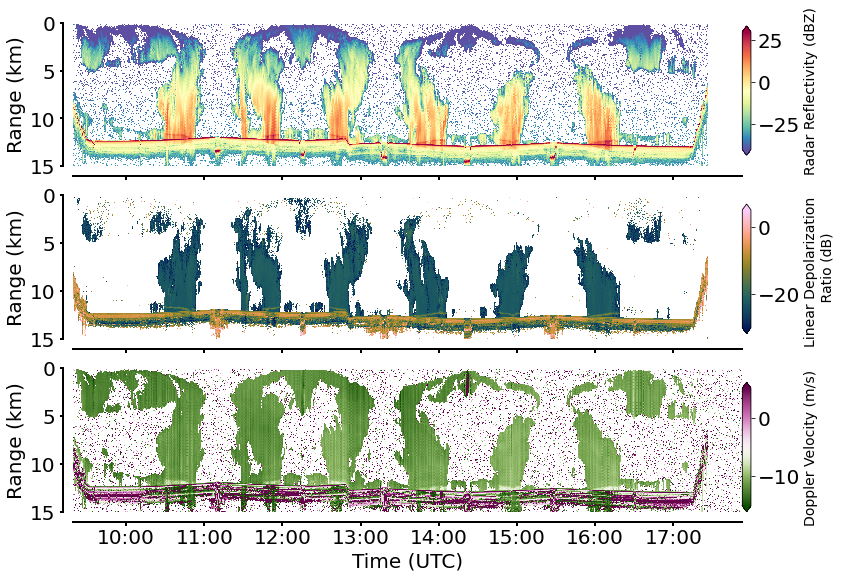

In [78]:
if perform_raw_quicklooks:
    import halodataplot
    Quick_Plotter=halodataplot.Quicklook_Plotter(prcs_cfg_dict)
    Radar_Quicklook=halodataplot.Radar_Quicklook(prcs_cfg_dict)
    Radar_Quicklook.plot_raw_radar_quicklook(raw_radar_ds)
    # CFAD plotting requires radar reflectivity as dataframe and 
    # then routine plot_single_radar_cfad also calculates the cfad 
    # by status method "calc_radar_cfad" in Data_Plotter
    #raw_radar_reflectivity=pd.DataFrame(data=np.array(raw_radar_ds["dBZg"].T[:]),
    #                                    index=np.array(raw_radar_ds["time"]),
    #                                    columns=np.array(raw_radar_ds["range"][:]))
    #Radar_Quicklook.plot_single_radar_cfad(raw_radar_reflectivity)

Plotting ...
Figure saved as :  C:\Users\u300737\Desktop\PhD_UHH_WIMI\Work\GIT_Repository\hamp_processing_py\hamp_processing_python/Flight_Data/HALO_AC3/plots/radiometer/Raw_HAMP_Tb_RF05_20220315.png


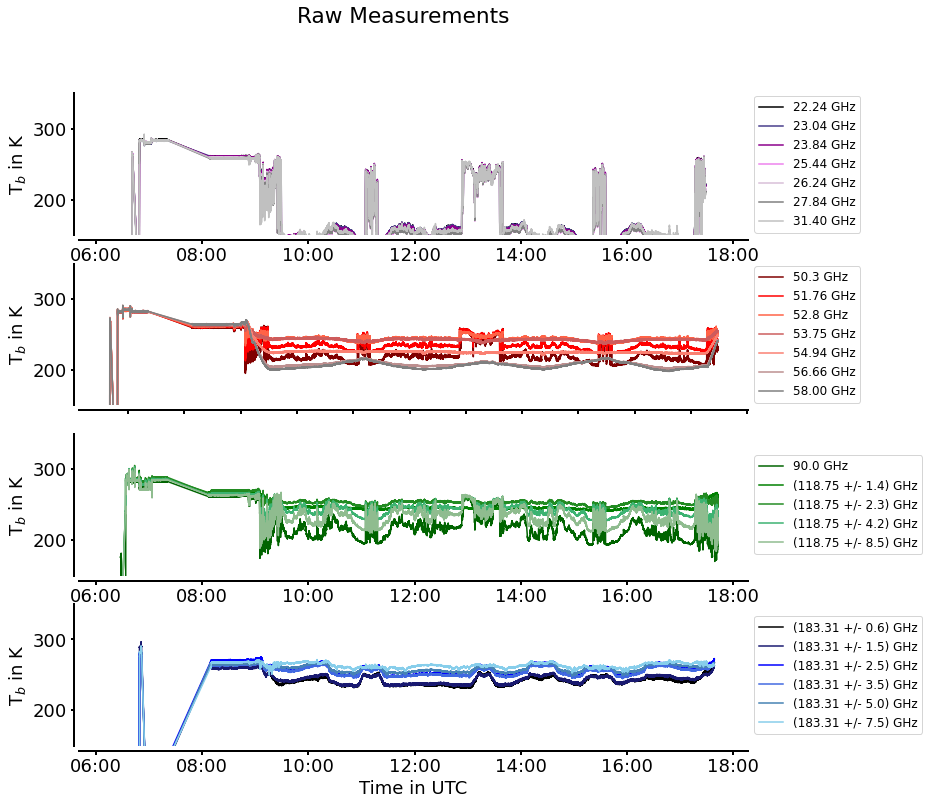

In [79]:
Radiometer_Quicklook=halodataplot.Radiometer_Quicklook(prcs_cfg_dict)
Radiometer_Quicklook.radiometer_tb_dict=HAMP_cls.raw_hamp_tb_dict
if perform_raw_quicklooks:
    Radiometer_Quicklook.plot_radiometer_TBs(date,raw_measurements=True)

In [20]:
#Radiometer_Quicklook=halodataplot.Radiometer_Quicklook(prcs_cfg_dict)
#Radiometer_Quicklook.radiometer_tb_dict=HAMP_cls.raw_hamp_tb_dict
#Radar_Quicklook=halodataplot.Radar_Quicklook(prcs_cfg_dict)

## Show Calibration Coefficients

In [22]:
#Radiometer
#[*prcs_cfg_dict["Flight_Dates_used"]][0]
if perform_raw_quicklooks:
    if calibrate_devices:
        Radiometer_Quicklook.plot_HAMP_TB_calibration_coeffs_of_flight()

In [23]:
#Radar
if calibrate_devices:
    Radar_cls.show_calibration()

# Error Identification

In [24]:
if perform_error_identification:
    import Error_Identification
    Error_Identification.main(function_configurated=False,
         prcs_cfg_dict=None)

In [25]:
prcs_cfg_dict

{'system': 'windows',
 'campaign': 'HALO_AC3',
 'campaign_path': 'C:\\Users\\u300737\\Desktop\\PhD_UHH_WIMI\\Work\\GIT_Repository\\hamp_processing_py\\hamp_processing_python/',
 'filenameprefix': 'HALO_AC3_HALO_',
 'save_path': 'C:\\Users\\u300737\\Desktop\\PhD_UHH_WIMI\\Work\\GIT_Repository\\hamp_processing_py\\hamp_processing_python/Save_path/',
 'comment': 'Preliminary data! Uncalibrated Data. Only use for preliminary work!',
 'contact': 'henning.dorff@uni-hamburg.de',
 't1': '20220225',
 't2': '20220225',
 'flight_date_used': '20220225',
 'correct_attitude': 'True',
 'add_radarmask': 'False',
 'unify_grid': 'False',
 'quicklooks': 'False',
 'remove_clutter': 'False',
 'remove_side_lobes': 'False',
 'remove_radiometer_errors': 'False',
 'version': '0',
 'subversion': '8',
 'missing_value': '-888',
 'fill_value': 'nan',
 'altitude_threshold': '4800',
 'add_radar_mask_values': 'False',
 'roll_threshold': '5',
 'land_mask': '1',
 'noise_mask': '1',
 'calibration_mask': '1',
 'surface_m

# Processing

In [26]:
if perform_processing:
    print("=========================== Processing ===============================")
    """
    Radar Attitude Correction
    """
    if Performance.str2bool(prcs_cfg_dict["correct_attitude"]):
        # Correct radar data for aircraft attitude
        print("Correct the radar attitude")
        RadarAttitude.run_att_correction(flightdates_use, prcs_cfg_dict)

    else:
        prcs_cfg_dict["radar_outDir"]=prcs_cfg_dict["device_data_path"]+"radar_mira/"
        for flight in flightdates_use:
            # Even if explicitly desired to not attitude correct radar files,
            # it is checked here, whether the corrected-file already exists
            if len(glob.glob(prcs_cfg_dict["radar_outDir"]+"*"+str(flight)+"*.nc"))>=1:
                print("Flight is already attitude-corrected, so skip this step")
        
            else:
                new_flightdates_use=pd.Series(flight,
                              index=flightdates_use[\
                                        flightdates_use==int(flight)].index)
                RadarAttitude.run_att_correction(new_flightdates_use,prcs_cfg_dict)
    
    """
    Add radar mask
    """
    if Performance.str2bool(prcs_cfg_dict["add_radarmask"]):
        # Create radar info mask
        RadarMasks.run_make_masks(flightdates_use, prcs_cfg_dict)
    
    """
    Run grid unification
    """
    if Performance.str2bool(prcs_cfg_dict["unify_grid"]):
        # Unify data from bahamas, dropsondes, radar, radiometer onto common grid
        UniGr.run_unify_grid(flightdates_use,prcs_cfg_dict)

=========================== Processing ===============================
Correct the radar attitude
C:\Users\u300737\Desktop\PhD_UHH_WIMI\Work\GIT_Repository\hamp_processing_py\hamp_processing_python/Flight_Data/HALO_AC3/bahamas/*20220225*
Use bahamas dataset for attitude.
Correct flight attitude without side lobes removal
using  BAHAMAS  attitude data
RADAR files ['C:\\Users\\u300737\\Desktop\\PhD_UHH_WIMI\\Work\\GIT_Repository\\hamp_processing_py\\hamp_processing_python/Flight_Data/HALO_AC3/radar\\HALO-AC3_HALO_hamp_mira_20220225_RF00.nc']
Start Attitude Coordinate Frame Rotation
C:\Users\u300737\Desktop\PhD_UHH_WIMI\Work\GIT_Repository\hamp_processing_py\hamp_processing_python/Flight_Data/HALO_AC3/radar\HALO-AC3_HALO_hamp_mira_20220225_RF00.nc
Variable name to find:  TIME
Att: selected first found variable; check if this is the right one!
Variable name to find:  IRS_ALT
Variable name to find:  IRS_PHI
Variable name to find:  IRS_THE
Variable name to find:  PS
Variable name to find:  R

C:\Users\u300737\Desktop\PhD_UHH_WIMI\Work\GIT_Repository\hamp_processing_py\hamp_processing_python\Measurement_Instruments.py:420: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  coll=np.hstack(coll.values())
C:\Users\u300737\Desktop\PhD_UHH_WIMI\Work\GIT_Repository\hamp_processing_py\hamp_processing_python\Measurement_Instruments.py:420: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  coll=np.hstack(coll.values())


Variable name to find:  TV
Variable name to find:  U
Variable name to find:  V
Variable name to find:  W
Variable name to find:  IRS_LAT
Variable name to find:  IRS_LON
Variable name to find:  IRS_THE
Variable name to find:  IRS_HDG
Variable name to find:  IRS_PHI
Variable name to find:  TS
Variable name to find:  ALPHA
Variable name to find:  BETA
Variable name to find:  H
Variable name to find:  HP
Variable name to find:  MC
Variable name to find:  QC
Variable name to find:  WA
Variable name to find:  WS
Variable name to find:  IRS_ALT
Adjust time series
Edit Data
Include Radar  SNRg
Include Radar  VELg
Include Radar  RMSg
Include Radar  LDRg
Include Radar  HSDco
Include Radar  HSDcx
Include Radar  Zg
bahamas_data allocated and cutted
Correct Attitude
Roll threshold:  5
Regrid radar variable: SNRg
[####################] 100% Regrid radar variable: VELg
[####################] 100% Regrid radar variable: RMSg
[####################] 100% Regrid radar variable: LDRg
[####################

C:\Users\u300737\Anaconda3\lib\site-packages\numpy\lib\scimath.py:122: RuntimeWarning: invalid value encountered in less
  if any(isreal(x) & (x < 0)):
C:\Users\u300737\Anaconda3\lib\site-packages\numpy\lib\scimath.py:324: RuntimeWarning: invalid value encountered in log10
  return nx.log10(x)
C:\Users\u300737\Desktop\PhD_UHH_WIMI\Work\GIT_Repository\hamp_processing_py\hamp_processing_python\RadarAttitude.py:900: RuntimeWarning: invalid value encountered in multiply
  dBZg = np.array(10*np.emath.log10(radar_data_corr['Zg'][:]))
C:\Users\u300737\Desktop\PhD_UHH_WIMI\Work\GIT_Repository\hamp_processing_py\hamp_processing_python\RadarAttitude.py:901: ComplexWarning: Casting complex values to real discards the imaginary part
  dBZg = dBZg.astype(np.float32)
C:\Users\u300737\Desktop\PhD_UHH_WIMI\Work\GIT_Repository\hamp_processing_py\hamp_processing_python\RadarAttitude.py:931: RuntimeWarning: invalid value encountered in multiply
  LDRg = np.array(10*np.emath.log10(radar_data_corr['LDRg'][

Create flags
Save file, this takes a while
Finished Coordinate Frame Rotation: Attitude Correction


### Processed radar

In [27]:
Radar_cls.open_processed_radar_data(reflectivity_is_calibrated=False)
Radar_cls.open_processed_radar_data(reflectivity_is_calibrated=True)    
calib_radar_ds=Radar_cls.calib_processed_radar_ds
uncalib_radar_ds=Radar_cls.processed_radar_ds

ValueError: attempt to get argmax of an empty sequence

In [ ]:
Radar_cls.calib_processed_radar_ds

In [ ]:
#if show_processed_results:
#    

In [ ]:
#Radar    
if show_processed_results:
    radar_df=pd.DataFrame(data=np.array(uncalib_radar_ds["dBZg"][:]),
                      index=pd.DatetimeIndex(np.array(uncalib_radar_ds.time[:])),
                      columns=np.array(uncalib_radar_ds["height"][:]))
    calib_radar_df=pd.DataFrame(data=np.array(calib_radar_ds["dBZg"][:].T),
                      index=pd.DatetimeIndex(np.array(uncalib_radar_ds.time[:])),
                      columns=np.array(calib_radar_ds["height"][:]))
#    Radar_Quicklook.plot_single_radar_cfad(radar_df,raw_measurements=False)
#    Radar_Quicklook.plot_single_radar_cfad(calib_radar_df,raw_measurements=False,is_calibrated=True)

In [ ]:
if show_processed_results:
    Radar_Quicklook.processed_radar=Radar_cls.calib_processed_radar_ds
    Radar_Quicklook.processed_radar_quicklook(is_calibrated=True,show_masks=True)

### Processed radiometer

In [ ]:
#Radiometer
if show_processed_results:
    HAMP_cls.get_HAMP_TB_calibration_coeffs_of_flight()
    #print(HAMP_cls.flight_tb_offset_coeff_ds)
    #print(HAMP_cls.flight_tb_slope_coeff_ds)
    Radiometer_Quicklook.plot_radiometer_TB_calibration_comparison()    